# Aperture photometry
This tutorial is a rudimentary introduction to using the [Photutils](https://photutils.readthedocs.io/en/stable/index.html) to perform aperture photometry. Before we begin, you must install the Photutils package. If you are using the Anaconda distribution of Python (recommended) you can install Photutils using the [conda-forge Anaconda channel](https://anaconda.org/conda-forge/photutils), run:
```
conda install -c conda-forge photutils
```
If you are using a different Python distribution, see the [Photoutils Installation page](https://photutils.readthedocs.io/en/stable/install.html).

## Outline
Here's an outline of the procedure we will follow:
 - Read the FITS file and display the image
 - Detect the sources locations using `DAOStarFinder()`
 - Perform aperture photometry on the selected sources using `aperture_photometry()`
 - Write the results to a CSV file

We start by loading some needed packages and set-up the image display.

In [1]:
# set-up for inline image display
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Set up a nice image display style. 
# See https://matplotlib.org/stable/tutorials/introductory/customizing.html for more information.
plt.style.use('im_disp.mplstyle') 

# import needed astropy modules
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.io import ascii

def get_magnitude(count_rate,zmag=25.0):
    """Function to compute instrumental magnitude from the count rate"""
    return -2.5*np.log10(count_rate) + zmag

## Read the FITS file and display the image
Now we read the `stars10_p.fits` file and display the image.

In [2]:
hdu_list = fits.open('images/stars10_p.fits')
hdu_list.info()
imheader = hdu_list[0].header
imdata = hdu_list[0].data
hdu_list.close()

Filename: images/stars10_p.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (512, 512)   float64   


Now we use `plt.imshow()` to display the image. You might find it easier to use [**SAOImageDS9**](https://sites.google.com/cfa.harvard.edu/saoimageds9/home) to find the approximate postion of one of the stars to get a plot of a stellar profile. 

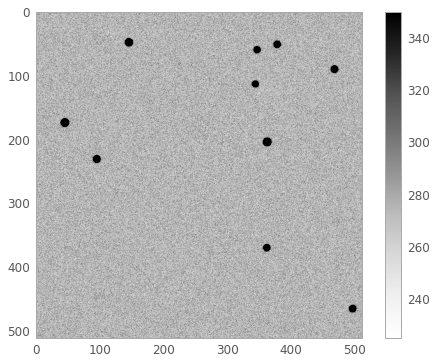

In [3]:
plt.imshow(imdata,cmap='Greys',vmin=225,vmax=350)
plt.colorbar()

## Detect the sources locations
DAOStarFinder finds stars by looking for objects in the image that have a peak pixel value above a specified threshold and that are shaped like a star. The threshold value is set with the keyword argument `threshold` and is the pixel value that triggers a source detection. We will set the `threshold` equal to five times the standard deviation of the sky background pixel values. Setting the threshold at this level makes it unlikely that DAOStarFinder will pick out a statistical fluctuations in the image as a possible source. 

### Measure background and seeing
We will use `sigma_clipped_stats()` from the `astropy.stats` package to estimate the sky background level and its standard deviation. Sigma clipping elliminates outliers in a distribution. We use sigma clipping to eliminate contamination of the median background and standard deviation by signal from the stars. 

In [4]:
mean, median, std = sigma_clipped_stats(imdata, sigma=3.0)
print(f'Sky background: mean = {mean:.5g}, median = {median:.5g}, standard deviation = {std:.3g}')

Sky background: mean = 275.06, median = 275, standard deviation = 10.2


DAOStarFinder assumes the sizes and shapes of the stellar profiles are similar to a 2D Gaussians. The Gaussian width is given by the keyword argument `fwhm` which is the full width at half maximum of the Gaussian. We will assume the stars have a spherical profile, although DAOStarFinder can accommodate elliptical profiles if needed. 

I will choose a bright star from the image above to estimate the `fwhm` of the stellar profiles. I chose the bright star at coordinates $x \approx$ 362 and $y \approx$ 205. I slice rows 185 through 226 and column 362 from the image and plot the slice to see the stellar profile. Remember, row values correspond to $y$ positions in the image and columns correspond to $x$ values.

Text(0, 0.5, 'Pixel value (ADU)')

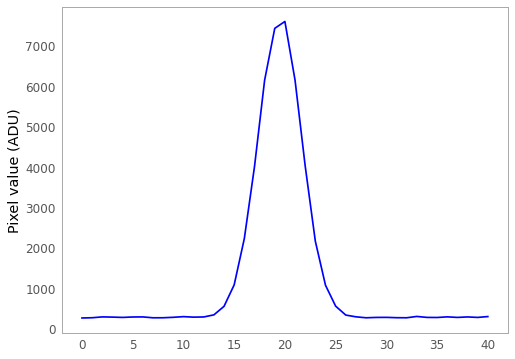

In [5]:
starprofile = imdata[185:226,362:363]
plt.plot(starprofile)
plt.ylabel('Pixel value (ADU)')

I estimate from the plot that the FWHM of the profile is about 6 pixels. This is a rough estimated of the seeing.

### Use `DAOStarFinder` to find stars
We're now ready to use DAOStarFinder. The first line of code below essentially sets parameters for DAOStarFinder, the next command finds the stars from the background subtracted image, and the final command prints out all the found sources and their *x* and *y* centroids.

In [6]:
seeing = 6.0
daofind = DAOStarFinder(fwhm=seeing,threshold=5.*std)
sources=daofind.find_stars(imdata-median)
sources['id', 'xcentroid','ycentroid'].pprint()

 id     xcentroid          ycentroid     
--- ------------------ ------------------
  1  145.0466740954732   48.5016507203063
  2  377.0507281761218  51.73905591582913
  3 345.67755179734627 60.173228935994196
  4  466.8857536825165  90.53124639723883
  5 342.93794409781896 113.71386649104907
  6  44.69673315390794 174.22874704995158
  7 361.43235753175156 204.49532973915282
  8  94.63674491019371  231.2429129007454
  9  360.9014844180293 370.14910718838206
 10  495.2414605123075  465.4347576764474


We must use care in interpreting *x* and *y* centroid coordinates. In [Photutils](https://photutils.readthedocs.io/en/stable/pixel_conventions.html), integer pixel coordinates fall at the center of the pixels and are 0-indexed, matching the Python 0-based indexing. That means that the first pixel is considered pixel `0`, and that pixel coordinate `0` is in the *center* of that pixel. Hence, the first pixel spans pixel coordinates `-0.5` to `0.5`. For a 2-dimensional array, `(x, y) = (0, 0)` corresponds to the center of the bottom, leftmost array element. Note that this differs from the [FITS](https://fits.gsfc.nasa.gov/fits_standard.html), and [SAOImageDS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) conventions, in which the center of the bottom, leftmost image array element is `(x, y) = (1, 1)`.

Another potential point of confusion is that in the `imdata` array, the `x` (column) coordinate corresponds to the second array index and the `y` (row) coordinate corresponds to the first index. This means that the pixel value at pixel coordinates `(x, y)` is given by `imdata[y, x]`. We can take care of this transposition of the indecies by defining a new `positions` array using the `np.transpose()` function.

In [7]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

## Perform aperture photometry 
The first step is to define the apertures and sky background annulus for each source. We do this with the `CircularAperture()` and `CircularAnnulus()` functions. We specify the circular apertures by giving each source position an aperture radius of `3.0*seeing`. We will take each associated sky annulus to have an inner radius just outside the aperture and extening far enough to give a good statisitical sample of the sky background. We then plot the apertures and annuli on the image using their `plot()` methods. 

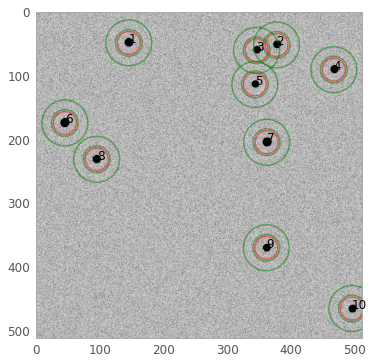

In [8]:
# define the aperture
r_a = 3*seeing
apertures = CircularAperture(positions, r=r_a)

# define the annulus
r_in = r_a + 3
r_out = r_in + 15
annulus = CircularAnnulus(positions, r_in=r_in, r_out=r_out)

# display the image
plt.imshow(imdata,cmap='Greys',vmin=225,vmax=350)

# label the sources
mylabels = sources['id']
for idx, txt in enumerate(mylabels):
    plt.annotate(txt,(positions[idx,0],positions[idx,1]))
    
# plot the aperture and the annulus for each source
apertures.plot(color='red', lw=1.5, alpha=0.5)
annulus.plot(color='green',lw=1.5, alpha=0.5)

The apertures and annuli are in the correct places, but there will be problems with the photometry of stars 2, 3, and 10. Stars 2 and 3 have star signal in the sky annuli. This will make the sky background estimation for these stars incorrect. The sky annulus for star 10 is outside the image area. This will ruin the sky background estimate for this star as well. We will either have to ignore the results for these three stars or use a more sophisticated technique to get accurate photometry for them. In this tutorial we will just ignore the results, but the [Photutils website](https://photutils.readthedocs.io/en/stable/aperture.html) illustrates how to use a masking feature to address these sorts of problems.

We will now use [`aperture_photometry()`](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.aperture_photometry.html#photutils.aperture.aperture_photometry) to sum the signal in the apertures and annuli. This function takes a minimum of two arguments. The first is the image data, in this case `imdata`. The second argument is a list of aperture and annulus objects. The function simply sums all the counts in the areas covered by apertures and annuli. By default, `aperture_photometry()` computes the exact fractional overlap of the aperture on each edge pixel and weights the pixel value contribution to the sum by that fraction. 

We start by making a list of appertures and annuli. The function returns a table with that includes the positions of the sources and the apperture and annulus sums.

In [9]:
aper_ann = [apertures,annulus]
phot_table = aperture_photometry(imdata, aper_ann)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,,
int64,float64,float64,float64,float64
1,145.0466740954732,48.5016507203063,405462.54345646285,738610.1184645466
2,377.0507281761218,51.73905591582913,330117.11010389443,776888.8955372665
3,345.67755179734627,60.173228935994196,320060.4155651439,786063.1146306929
4,466.8857536825165,90.53124639723883,347596.3050155187,739813.3056832174
5,342.93794409781896,113.71386649104907,312812.28094199277,737540.1655207048
6,44.69673315390794,174.22874704995158,491508.4076196709,739166.1470230892
7,361.43235753175156,204.49532973915282,499226.64906523854,738412.1676670559
8,94.63674491019371,231.2429129007454,357215.1580028896,738434.8191834027


The `aperture_sum_0` column of the table gives the sums of the counts in `apertures`, and `aperture_sum_1` gives the counts in `annulus`. 

We now need to compute the sky background levels per pixel by dividing `aperture_sum_1` by the area of the annulus which is stored in the `annulus.area` attribute and append this information to `phot_table`.

In [10]:
phot_table['mean_bkg'] = phot_table['aperture_sum_1']/annulus.area
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,mean_bkg
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,145.0466740954732,48.5016507203063,405462.54345646285,738610.1184645466,274.9788336171298
2,377.0507281761218,51.73905591582913,330117.11010389443,776888.8955372665,289.2297262174481
3,345.67755179734627,60.173228935994196,320060.4155651439,786063.1146306929,292.64521701914833
4,466.8857536825165,90.53124639723883,347596.3050155187,739813.3056832174,275.42677091143725
5,342.93794409781896,113.71386649104907,312812.28094199277,737540.1655207048,274.5804984127131
6,44.69673315390794,174.22874704995158,491508.4076196709,739166.1470230892,275.1858387483399
7,361.43235753175156,204.49532973915282,499226.64906523854,738412.1676670559,274.90513806646396
8,94.63674491019371,231.2429129007454,357215.1580028896,738434.8191834027,274.9135710507801


You can see from the table that the sky backgrounds estimated for stars 2, 3, and 10 are significantly different than the rest of the background estimates. This is because of the problems discussed above.

We now subtract the sky background contribution from the number of source counts. The number of source counts is stored in the `aperture_sum_0` column of `phot_table`. We compute the count rate by dividing the source counts by the exposure time that is stored in the image header (`imheader['EXPTIME']`).  

In [11]:
bkg_contribution = phot_table['mean_bkg'] * apertures.area
source_counts = phot_table['aperture_sum_0'] - bkg_contribution
count_rate = source_counts/imheader['EXPTIME']

Finally, we compute the instrumental magnitudes for each source using the `get_magnitude()` function defined above. We store all this information by appending it to `phot_table`. 

In [12]:
mag = get_magnitude(count_rate)

phot_table['count_rate'] = count_rate
phot_table['mag'] = mag
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,mean_bkg,count_rate,mag
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,145.0466740954732,48.5016507203063,405462.54345646285,738610.1184645466,274.9788336171298,2092.803046252683,16.698179103007103
2,377.0507281761218,51.73905591582913,330117.11010389443,776888.8955372665,289.2297262174481,595.2851264084874,18.063187421116908
3,345.67755179734627,60.173228935994196,320060.4155651439,786063.1146306929,292.64521701914833,369.73111438311173,18.580285000587125
4,466.8857536825165,90.53124639723883,347596.3050155187,739813.3056832174,275.42677091143725,1120.766661733062,17.376211990078154
5,342.93794409781896,113.71386649104907,312812.28094199277,737540.1655207048,274.5804984127131,555.3896018849016,18.138505638644283
6,44.69673315390794,174.22874704995158,491508.4076196709,739166.1470230892,275.1858387483399,3523.3890229890394,16.13259850756628
7,361.43235753175156,204.49532973915282,499226.64906523854,738412.1676670559,274.90513806646396,3656.7883552953776,16.09225043671793
8,94.63674491019371,231.2429129007454,357215.1580028896,738434.8191834027,274.9135710507801,1289.7871087143888,17.22370492026089


The `phot_table` is a special class called a [**QTable**](https://docs.astropy.org/en/stable/api/astropy.table.QTable.html#astropy.table.QTable). A [**QTable**](https://docs.astropy.org/en/stable/api/astropy.table.QTable.html#astropy.table.QTable) can store all sorts of different data types and, as we have seen, it's easy to add columns to the table. A **QTable** has useful `write` method that we will now use to write our data to a CSV file.

In [13]:
phot_table.write('photometry_example.csv',format='csv',overwrite=True)

## Summary

This notebook outlines the basic steps needed to use Photutils to perform simple aperture photometry. However, the Photutils package is capable of much more, and its developers are constantly adding new features. For example, Photutils can do PSF photometry, measure the brightness of non-circular sources, and mask unwanted data.  See the [Photutils documentation website](https://photutils.readthedocs.io/en/stable/) for code examples and complete documentation. You can also download the script `aperture_photometry.py` from the `code` directory to use as a starting point for writing your own photometry code.  